In [17]:
%reset -f

In [18]:
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from typing import List

In [19]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [20]:
from utils_torch import *

In [21]:
def create_rod_with_nodes_and_edges(num_nodes: int):
    nodes = []
    edges = []
    for i in range(num_nodes):
        nodes.append(np.array([i * 0.1, 0.0, 0.0], dtype=np.float32))
        if i<num_nodes-1:
            edges.append([i, i+1])
    return nodes, edges

def build_rod_springs(nodes):
    num_nodes = len(nodes)

    stretch = []
    bend = []
    d1_init = []
    for j in range(num_nodes - 1):
        d1_init.append(np.array([0.0, 0.0, 1.0]))

    for i in range(num_nodes):
        if i == 0:
            # boundary at left end: stencil (0,1), no right neighbor
            l0 = np.linalg.norm(nodes[i+1] - nodes[i]).astype(np.float32)
            l1 = 0.0
            leff = 0.5 * l0
            stretch.append((i, i+1, -1, True, l0, l1, leff))

        elif i == num_nodes - 1:
            # boundary at right end: stencil (n-2,n-1)
            l0 = np.linalg.norm(nodes[i] - nodes[i-1]).astype(np.float32)
            l1 = 0.0
            leff = 0.5 * l0
            stretch.append((i-1, i, -1, True, l0, l1, leff))

        else:
            # internal node i uses (i-1,i,i+1)
            l0 = np.linalg.norm(nodes[i] - nodes[i-1]).astype(np.float32)
            l1 = np.linalg.norm(nodes[i+1] - nodes[i]).astype(np.float32)
            leff = 0.5 * (l0 + l1)
            stretch.append((i-1, i, i+1, False, l0, l1, leff))
            # bend.append((i-1, i, i+1))
            bend.append((i-1, i, i+1, i-1, i)) # with edge index

    # Convert to torch tensors for class storage
    stretch = np.array(stretch, dtype=object)

    stretch_idx = torch.tensor(stretch[:, 0:3].astype(np.int64))  # (S,3) [i,j,k_raw]
    stretch_is_boundary = torch.tensor(stretch[:, 3].astype(bool))# (S,)
    stretch_l0 = torch.tensor(stretch[:, 4].astype(np.float32))   # (S,)
    stretch_l1 = torch.tensor(stretch[:, 5].astype(np.float32))   # (S,)
    stretch_leff = torch.tensor(stretch[:, 6].astype(np.float32)) # (S,)

    bend_idx = torch.tensor(np.array(bend, dtype=np.int64))       # (Sb,3)

    return bend_idx, stretch_idx, stretch_is_boundary, stretch_l0, stretch_l1, stretch_leff, d1_init


In [22]:
def build_initial_state(nodes: List[np.ndarray]) -> np.ndarray:
    """
    q0: stacked node positions (3*num_nodes) plus edge DOFs (num_nodes-1)
    v0: zeros like q0
    x0: concat(q0, v0)
    """
    num_nodes = len(nodes)

    q0_nodes = np.array(nodes, dtype=np.float32).reshape(-1)  # (3*num_nodes,)
    q0_edges = np.zeros(num_nodes - 1, dtype=np.float32)      # (num_nodes-1,)
    q0 = np.concatenate([q0_nodes, q0_edges], axis=0)

    v0 = np.zeros_like(q0, dtype=np.float32)
    x0 = np.concatenate([q0, v0], axis=0)  # (2*ndof,)
    return x0

In [23]:
# --- build a simple rod: 3 DOF per node (x,y,z) ---
num_nodes = 5
nodes, edges  = create_rod_with_nodes_and_edges(num_nodes)  # 11 nodes -> ndof = 33
x0 = build_initial_state(nodes)
q0 = x0[: (x0.size // 2)]
ndof = q0.size

# convert x0 to torch.tensor
x0 = torch.Tensor(x0)
print("Initial positions q0:", q0)
print("Initial state x0:", x0)

# create springs (3 consecutive nodes and effective length)
bend_idx, stretch_idx, stretch_is_boundary, stretch_l0, stretch_l1, stretch_leff, d1_init = build_rod_springs(nodes)

# Material properties
E = 1e7  # Young's modulus
r0 = 0.01  # radius
A = np.pi * r0**2  # cross-sectional area
I = 0.25 * np.pi * r0**4  # area moment of inertia
rho = 1200  # density
mass = rho*A*1  # mass per segment (length 1 m)
m_per_node = mass/num_nodes

EA = E * A  # axial stiffness
EI = E * I  # bending stiffness
stiffness_matrix = torch.tensor([[EA, 0.0],
                                  [0.0, EI]], dtype=torch.float32)
stiffnesses = stiffness_matrix.to(device)

# print("Stretch springs:", stretch_springs)
# print("Bend springs:", bend_springs)
print(f"EA={EA:.3e}, EI={EI:.3e}")


Initial positions q0: [0.  0.  0.  0.1 0.  0.  0.2 0.  0.  0.3 0.  0.  0.4 0.  0.  0.  0.  0.
 0. ]
Initial state x0: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.3000, 0.0000, 0.0000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
EA=3.142e+03, EI=7.854e-02


In [24]:
# from strains_torch import get_strain_stretch2D_torch, get_strain_curvature_3D_torch
from strains_torch_copy import get_strain_stretch2D_torch, get_strain_curvature_3D_torch

In [25]:
class AnalyticalODE(nn.Module):
    def __init__(self, edges, n_nodes: int, a1_init, q_init,
                 m_per_dof: float = 1.0, c_per_dof: float = 0.1, 
                 g: float = 9.81, freeDOF: List[int]=None, 
                 bend_idx: torch.Tensor = None, stretch_idx: torch.Tensor = None,
                    stretch_is_boundary: torch.Tensor = None,
                    stretch_l0: torch.Tensor = None, stretch_l1: torch.Tensor = None, stretch_leff: torch.Tensor = None,
                 stiffnesses: torch.Tensor = None, dtype=torch.float32):
        super().__init__()
        
        self.n_nodes = n_nodes
        self.n_edges = n_nodes-1
        self.ndof = 3*n_nodes + self.n_edges
        self.freeDOF = freeDOF
        self.call_count = 0
        self.register_buffer("edges", torch.as_tensor(edges, dtype=torch.long))
        self.register_buffer("a1_init", a1_init)
        self.register_buffer("q_init", q_init)

        # Indices / masks
        if freeDOF is None:
            freeDOF = list(range(ndof))
        free_idx = torch.as_tensor(freeDOF, dtype=torch.long)
        fixed_mask = torch.ones(ndof, dtype=torch.bool)
        fixed_mask[free_idx] = False
        self.register_buffer("free_idx", free_idx)
        self.register_buffer("fixed_mask", fixed_mask)
        self.register_buffer("free_mask", ~fixed_mask)  # same shape

        # Diagonal mass and damping for now (easy to replace with full matrices later)
        M = torch.eye(ndof) * m_per_dof       # (ndof, ndof)
        C = torch.eye(ndof) * c_per_dof       # (ndof, ndof)

        # Gravity as external force: acts in z only (every 3rd DOF starting from index 2)
        f_ext = torch.zeros(ndof)
        f_ext[2::3] = -m_per_dof * g          # (ndof,)
        # f_ext[0::3] = -m_per_dof * g          # (ndof,) # gravity in x-direction for testing

        # Register as buffers so dtype/device track the module (and no grads)
        self.register_buffer("M", M)
        self.register_buffer("C", C)
        self.register_buffer("f_ext", f_ext)

        # Pre-slice free blocks once (for diagonal M this is overkill but scales)
        self.register_buffer("M_ff", M.index_select(0, free_idx).index_select(1, free_idx))
        self.register_buffer("C_ff", C.index_select(0, free_idx).index_select(1, free_idx))

        # stencils
        self.register_buffer("bend_springs", bend_idx)
        self.register_buffer("stretch_springs", stretch_idx)

        self.register_buffer("stretch_is_boundary", stretch_is_boundary)
        self.register_buffer("stretch_l0", stretch_l0)
        self.register_buffer("stretch_l1", stretch_l1)
        self.register_buffer("stretch_leff", stretch_leff)

        # stiffnesses
        self.register_buffer("stiffnesses", stiffnesses)
        self.register_buffer("EA", stiffnesses[0,0])
        self.register_buffer("EI", stiffnesses[1,1])


    def elastic_bending_force(self, q: torch.Tensor, m1, m2) -> torch.Tensor:
        """
        q: (..., ndof), ndof = 3*n_nodes
        returns f_bend: (..., ndof)
        """
        device = q.device
        springs = self.bend_springs.to(device)      # (Sb,3) all internal
        i = springs[:, 0].long()
        j = springs[:, 1].long()
        k = springs[:, 2].long()

        edge_e_id = springs[:, 3].long()
        edge_f_id = springs[:, 4].long()

        m1_e = m1.index_select(-2, edge_e_id)   # (..., Sb, 3)
        m1_f = m1.index_select(-2, edge_f_id)
        m2_e = m2.index_select(-2, edge_e_id)
        m2_f = m2.index_select(-2, edge_f_id)

        l_eff = 0.1

        q_in = q.detach().requires_grad_(True)
        q_nodes = q_in.view(*q_in.shape[:-1], -1, 3)   # (..., n_nodes, 3)

        node0 = q_nodes.index_select(-2, i)            # (..., Sb, 3)
        node1 = q_nodes.index_select(-2, j)
        node2 = q_nodes.index_select(-2, k)

        kappa1, kappa2 = get_strain_curvature_3D_torch(node0, node1, node2, m1_e, m2_e, m1_f, m2_f)  # (..., Sb)

        E_spring = 0.5 * (self.EI / l_eff) * (kappa1**2 + kappa2**2)               # (..., Sb)
        E_total = E_spring.sum(dim=-1)                                  # (...)

        (dE_dq,) = torch.autograd.grad(E_total, q_in, create_graph=True)
        return -dE_dq


    def elastic_stretch_force(self, q: torch.Tensor) -> torch.Tensor:
        """
        q: (..., ndof)
        returns f_stretch: (..., ndof)
        """
        device = q.device
        springs = self.stretch_springs.to(device)          # (S,3) with k_raw possibly -1
        is_boundary = self.stretch_is_boundary.to(device)  # (S,) bool
        l0 = self.stretch_l0.to(device)                    # (S,)
        l1 = self.stretch_l1.to(device)                    # (S,)
        leff = self.stretch_leff.to(device)                # (S,)

        i = springs[:, 0].long()
        j = springs[:, 1].long()
        k_raw = springs[:, 2].long()
        k_safe = k_raw.clamp_min(0)                        # dummy index for boundary

        q_in = q.detach().requires_grad_(True)
        q_nodes = q_in.view(*q_in.shape[:-1], -1, 3)       # (..., n_nodes, 3)

        node0 = q_nodes.index_select(-2, i)                # (..., S, 3)
        node1 = q_nodes.index_select(-2, j)
        node2 = q_nodes.index_select(-2, k_safe)           # (..., S, 3) (dummy for boundary)

        # make is_boundary broadcastable to (..., S)
        # (works for arbitrary leading batch dims)
        isb = is_boundary.view(*([1] * (q_in.dim() - 1)), -1)

        # l0,l1,leff broadcast too
        l0b = l0.view(*([1] * (q_in.dim() - 1)), -1)
        l1b = l1.view(*([1] * (q_in.dim() - 1)), -1)
        leffb = leff.view(*([1] * (q_in.dim() - 1)), -1)

        longitudinal_strain = get_strain_stretch2D_torch(node0, node1, node2, l0b, l1b, isb)

        # energy weight: I’d use leff (matches how you computed it in spring building)
        E_spring = 0.5 * self.EA * leffb * longitudinal_strain**2       # (..., S)
        E_total = E_spring.sum(dim=-1)                                  # (...)

        (dE_dq,) = torch.autograd.grad(E_total, q_in, create_graph=True)
        return -dE_dq


    def elastic_force(self, q: torch.Tensor, m1, m2, ref_twist) -> torch.Tensor:
        f_stretch = self.elastic_stretch_force(q)
        f_bend = self.elastic_bending_force(q, m1, m2)
        f_elastic = f_stretch + f_bend
        return f_elastic
    
    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        x shape: (..., 2*ndof)
        Returns dx/dt with same shape.
        """
        ndof = self.ndof
        q = x[..., :ndof]        # (..., ndof)
        v = x[..., ndof:]        # (..., ndof)

        thetas = q[..., 3*self.n_nodes:]
        q_nodes = q[..., :3*self.n_nodes]

        thetas = torch.zeros_like(thetas)  # for testing zero twist

        # compute tangents
        tangents = compute_tangent(q_nodes, self.edges)

        # Compute time parallel
        q_init_nodes = self.q_init[:3*self.n_nodes]
        a1, a2 = compute_time_parallel(self.a1_init, q_init_nodes, q_nodes, edges=self.edges)

        m1, m2 = compute_material_directors(thetas, a1, a2)

        reftwist = compute_reference_twist(self.edges, a1, tangents)

        # Forces
        f_el = self.elastic_force(q_nodes, m1, m2, reftwist)          # (..., ndof)
        # pad with zeros for edge DOFs
        f_el_full = torch.zeros_like(q)
        f_el_full[..., :3*self.n_nodes] = f_el
        f_damp = torch.matmul(v, self.C.T)    # (..., ndof)

        # External + elastic + damping
        rhs = -f_damp + f_el_full + self.f_ext     # (..., ndof)
        # Free-DOF solve
        idx = self.free_idx
        rhs_f = rhs.index_select(-1, idx)     # (..., n_free)
        v_f   = v.index_select(-1, idx)       # (..., n_free)

        M_ff = self.M_ff
        a_f = torch.linalg.solve(M_ff, rhs_f.unsqueeze(-1)).squeeze(-1)  # (..., n_free)

        # Scatter back to full
        a_full = torch.zeros_like(v)
        v_full = torch.zeros_like(v)
        a_full[..., idx] = a_f
        v_full[..., idx] = v_f

        dxdt = torch.cat([v_full, a_full], dim=-1)

        # Logging
        self.call_count += 1
        if self.call_count % 100 == 0:
            ke = 0.5 * torch.sum(v_full**2)
            print(f"[{self.call_count}] t={t.item():.3f}, KE={ke.item():.3e}")

        return dxdt


In [26]:
bend_idx = torch.as_tensor(bend_idx, dtype=torch.int64, device=device)
stretch_idx = torch.as_tensor(stretch_idx, dtype=torch.int64, device=device)
stretch_is_boundary = torch.as_tensor(stretch_is_boundary, dtype=torch.bool, device=device)

stretch_l0 = torch.as_tensor(stretch_l0, dtype=torch.float32, device=device)
stretch_l1 = torch.as_tensor(stretch_l1, dtype=torch.float32, device=device)
stretch_leff = torch.as_tensor(stretch_leff, dtype=torch.float32, device=device)

stiffnesses = torch.as_tensor(stiffnesses, dtype=torch.float32, device=device)
edges_t = torch.as_tensor(edges, dtype=torch.int64, device=device)
q_init = torch.as_tensor(q0, dtype=torch.float32, device=device)
d1_init_np = np.asarray(d1_init, dtype=np.float32)      # or np.stack(d1_init).astype(np.float32)
a1_init = torch.from_numpy(d1_init_np).to(dtype=torch.float32, device=device)

In [27]:
# # --- set up and integrate ---
ndof = q0.size
freeDOF = list(range(6, 3*num_nodes))  # fix first two nodes (first 6 DOF)
odefunc = AnalyticalODE(edges=edges_t,
                   n_nodes=num_nodes,
                   a1_init = a1_init,
                   q_init = q_init,
                  m_per_dof=m_per_node,
                  c_per_dof=0.1,
                  g=9.81,
                  freeDOF=freeDOF,
                  bend_idx=bend_idx, 
                  stretch_idx=stretch_idx,
                  stretch_is_boundary=stretch_is_boundary,
                  stretch_l0=stretch_l0, stretch_l1=stretch_l1, stretch_leff=stretch_leff,
                  stiffnesses=stiffnesses,
                  dtype=torch.float32).to(device)



In [28]:
dtype=torch.float32
# time discretization
T = 0.5
dt = 0.001
steps = int(T/dt) + 1
t = torch.linspace(0., T, steps, dtype=dtype)

# Now move all inputs / reference data
x0    = x0.to(device=device, dtype=dtype)
t     = t.to(device=device, dtype=dtype)
traj = odeint(odefunc, x0, t, method='rk4')   # (steps, 2*ndof)

[100] t=0.025, KE=7.851e-02
[200] t=0.050, KE=2.616e-01
[300] t=0.075, KE=5.221e-01
[400] t=0.100, KE=8.331e-01
[500] t=0.125, KE=1.108e+00
[600] t=0.150, KE=1.319e+00
[700] t=0.175, KE=1.418e+00
[800] t=0.200, KE=1.355e+00
[900] t=0.225, KE=1.182e+00
[1000] t=0.250, KE=9.014e-01
[1100] t=0.275, KE=5.594e-01
[1200] t=0.300, KE=2.600e-01
[1300] t=0.325, KE=5.575e-02
[1400] t=0.350, KE=4.711e-03
[1500] t=0.375, KE=1.055e-01
[1600] t=0.400, KE=3.030e-01
[1700] t=0.425, KE=5.508e-01
[1800] t=0.450, KE=7.585e-01
[1900] t=0.475, KE=8.825e-01
[2000] t=0.500, KE=9.232e-01


In [29]:
print("Solution shape:", traj.shape)           # (T, 2*ndof)
q_traj = traj[:, :3*num_nodes]                        # (T, ndof)
v_traj = traj[:, 3*num_nodes:]                        # (T, ndof)
print("q_traj[0]:", q_traj[0, :6])
print("v_traj[0]:", v_traj[0, :6])


Solution shape: torch.Size([501, 38])
q_traj[0]: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SliceBackward0>)
v_traj[0]: tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)


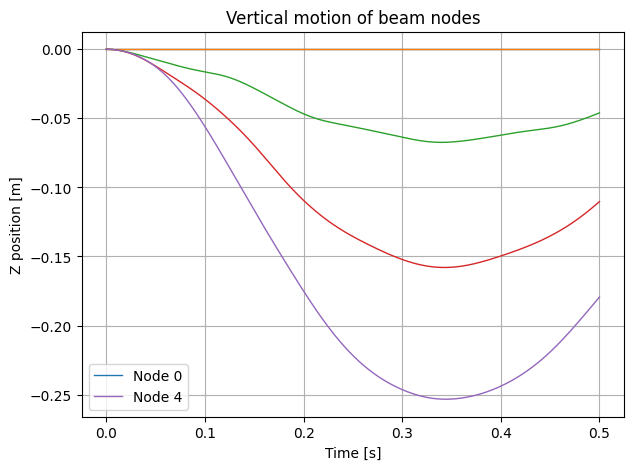

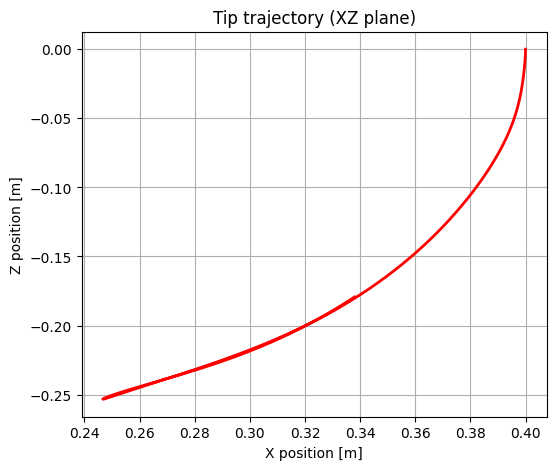

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert trajectory to numpy
q_traj_np = q_traj.detach().cpu().numpy().reshape(len(t), num_nodes, 3)
t_np = t.detach().cpu().numpy()

# Plot Z-displacement (vertical motion) of each node
plt.figure(figsize=(7, 5))
for i in range(num_nodes):
    plt.plot(t_np, q_traj_np[:, i, 2], label=f'Node {i}' if i in [0, num_nodes-1] else "", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Z position [m]")
plt.title("Vertical motion of beam nodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot trajectory of beam tip (last node)
plt.figure(figsize=(6, 5))
plt.plot(q_traj_np[:, -1, 0], q_traj_np[:, -1, 2], 'r-', lw=2)
plt.xlabel("X position [m]")
plt.ylabel("Z position [m]")
plt.title("Tip trajectory (XZ plane)")
plt.grid(True)
plt.show()


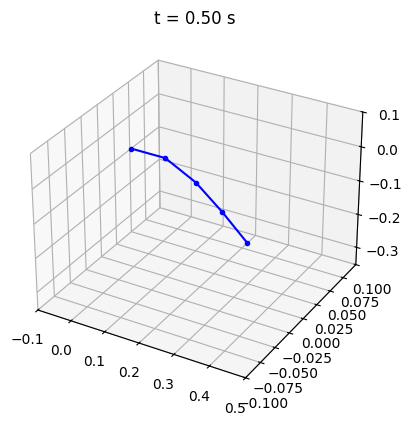

In [31]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.plot(q_traj_np[frame, :, 0],
            q_traj_np[frame, :, 1],
            q_traj_np[frame, :, 2],
            'b.-')
    ax.set_xlim([q_traj_np[:, :, 0].min()-0.1, q_traj_np[:, :, 0].max()+0.1])
    ax.set_ylim([q_traj_np[:, :, 1].min()-0.1, q_traj_np[:, :, 1].max()+0.1])
    ax.set_zlim([q_traj_np[:, :, 2].min()-0.1, q_traj_np[:, :, 2].max()+0.1])
    ax.set_title(f"t = {t[frame]:.2f} s")
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 10), interval=50)
ani.save("analytical_both_springs.gif", writer="ffmpeg", fps=20)
plt.show()
